In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [3]:
test_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


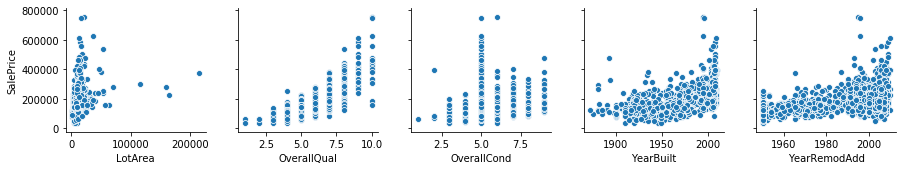

In [6]:
sns.pairplot(train_data, x_vars=["LotArea", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd"], y_vars=["SalePrice"])

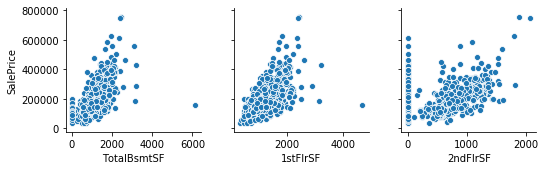

In [7]:
sns.pairplot(train_data, x_vars=["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"], y_vars=["SalePrice"])

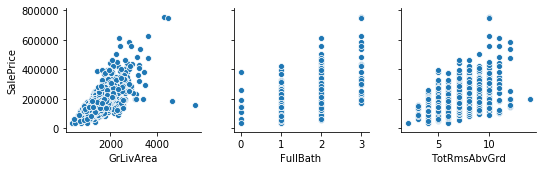

In [9]:
sns.pairplot(train_data, x_vars=["GrLivArea", "FullBath", "TotRmsAbvGrd"], y_vars=["SalePrice"])

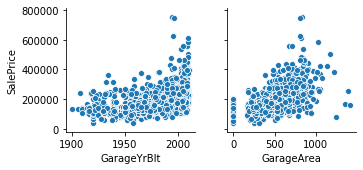

In [10]:
sns.pairplot(train_data, x_vars=["GarageYrBlt", "GarageArea"], y_vars=["SalePrice"])

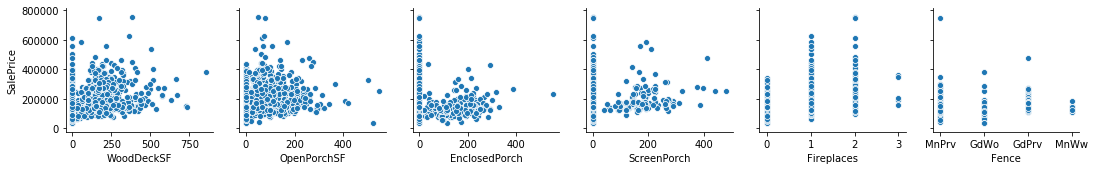

In [11]:
sns.pairplot(train_data, x_vars=["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch", "Fireplaces", "Fence"], y_vars=["SalePrice"])

In [12]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [34]:
from sklearn.metrics import mean_squared_log_error

In [14]:
cols = ["Id", "LotArea", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "FullBath", "TotRmsAbvGrd", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch", "Fireplaces", "Fence", "GarageYrBlt", "GarageArea"]

In [36]:
def df_clean(dataframe):
    dataframe = dataframe[cols]
    dataframe = dataframe.fillna(value=0, axis=1)
    dataframe.loc[(dataframe["Fence"] == "GdPrv") | (dataframe["Fence"] == "MnWw"), "Fence"] = 1
    dataframe.loc[(dataframe["Fence"] == "GdWo") | (dataframe["Fence"] == "MnPrv"), "Fence"] = 0
    return dataframe

In [37]:
test_df = df_clean(test_data)

In [38]:
test_df.shape

(1459, 20)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(train_df, train_data["SalePrice"], test_size=0.33)

In [48]:
regs = [RandomForestRegressor(), DecisionTreeRegressor()]

In [51]:
scores = []
for reg in regs:
    reg.fit(x_train, y_train)
    pred = reg.predict(x_test)
    scores.append(mean_squared_log_error(y_test, pred))
    
regressor = scores.index(min(scores))
y_pred = regs[regressor].predict(test_df)

In [52]:
scores

[0.02618260157574629, 0.04917362705586169]

In [55]:
test_df["SalePrice"] = y_pred

In [56]:
test_df[["Id", "SalePrice"]].to_csv(path_or_buf="./submission.csv", index=False)